In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from geomloss import SamplesLoss

# Custom library
sys.path.insert(0, "../")
from utils import class_sampler, grid_plot
from models.pretrained import MnistALI, MnistClassifier
import schedulers
from schedulers import *
from constraints import *
from objectives import *
from distances import *
from methods import *

# Load models
device = 'cuda'
epsilon = 0.3
generator = MnistALI()
classifier = MnistClassifier()
combined = lambda z: classifier(generator.decode(z))

# Sample data
torch.manual_seed(1)
z_data = torch.cat([class_sampler(classifier, generator, c, samples=2, threshold=0.99, device=device) for c in range(10)])
y_data = torch.tensor([[c]*2 for c in range(10)], device=device).flatten()
x_data = generator.decode(z_data)
z0 = z_data.clone()
z = torch.roll(z0.clone(), 2, dims=0)

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


C:\Users\cerma\anaconda3\envs\ml\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### No attack

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9],
       device='cuda:0')


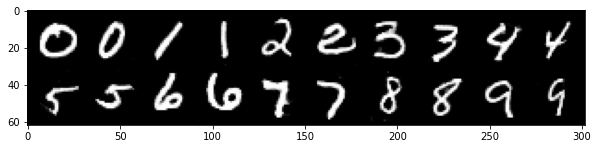

In [7]:
print(classifier(x_data).argmax(1))
grid_plot(x_data, nrows=10)

# 1. Image attacks

### FGSM on images
- Untargeted attack with l-inf epsilon = 0.3
- Clip images to pixel range

tensor([2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8],
       device='cuda:0')


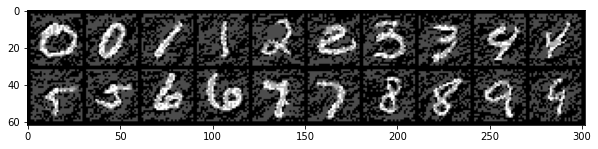

In [10]:
x_per = fgsm(x_data, y_data, classifier, epsilon=epsilon)

print(classifier(x_per).argmax(1))
grid_plot(x_per, nrows=10)

### PGD on images
#### Untargeted,
- l-inf, 50 iterations

tensor([2, 6, 2, 4, 8, 3, 5, 9, 9, 8, 8, 3, 3, 5, 4, 9, 3, 5, 4, 4],
       device='cuda:0')


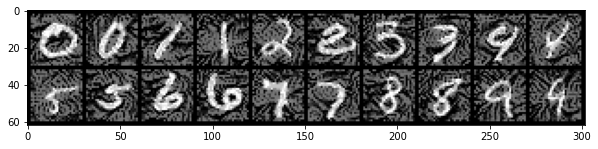

In [11]:
objective = Objective(y_data, nn.CrossEntropyLoss(), classifier, targeted=False)
projection = ProjectionLinf(epsilon)
x_per = projected_gd(x_data, objective, projection, grad_norm='sign', steps=50, step_size=0.1, clip=(-1, 1))

print(classifier(x_per).argmax(1))
grid_plot(x_per, nrows=10)

#### Targeted
- l-inf, 50 iterations

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')


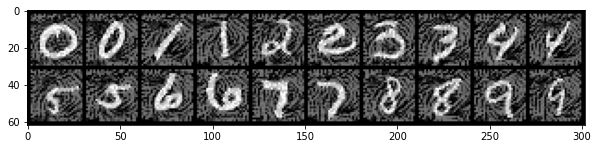

In [13]:
objective = Objective(y_data*0, nn.CrossEntropyLoss(), classifier, targeted=True)
projection = ProjectionLinf(epsilon)
x_per = projected_gd(x_data, objective, projection, grad_norm='sign', steps=50, step_size=0.1, clip=(-1, 1))

print(classifier(x_per).argmax(1))
grid_plot(x_per, nrows=10)

### Compare projection on l2 ball basic vs binary search

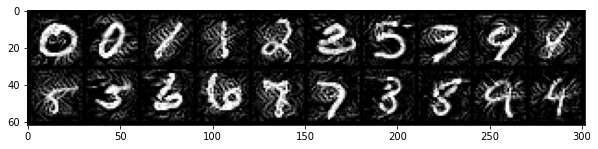

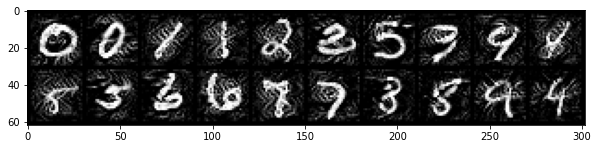

tensor(16.9485, device='cuda:0', grad_fn=<SumBackward0>)


In [14]:
objective = Objective(y_data, nn.CrossEntropyLoss(), classifier, targeted=False)

# Projection using norm
projection = ProjectionL2(5.0)
x_per1 = projected_gd(x_data, objective, projection, grad_norm='l2', steps=10, step_size=1.0, clip=(0, 1))

# Projection using binary search
constraint = ConstraintDistance(x_data, L2(), 5.0)
projection = ProjectionBinarySearch(constraint, inside=True, threshold=0.00001)
x_per2 = projected_gd(x_data, objective, projection, grad_norm='l2', steps=10, step_size=1.0, clip=(0, 1))

grid_plot(x_per1, nrows=10)
grid_plot(x_per2, nrows=10)
print((x_per1 - x_per2).abs().sum())

# 2. Latent attacks

## 2.1 Minimize model loss
- distance is constraint

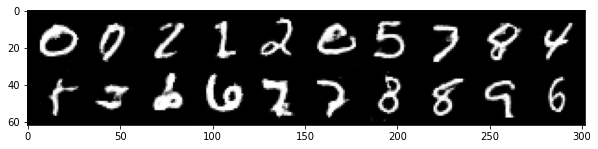

tensor([0, 0, 2, 1, 2, 0, 5, 7, 8, 4, 5, 3, 6, 6, 2, 7, 8, 8, 9, 6],
       device='cuda:0')

In [15]:
# Minimize losss (crossnetropy) such that ||x0-x||2 < epsilon
distance = L2(Decoded(generator))
constraint = ConstraintDistance(z_data, distance, 5.0)
projection = ProjectionBinarySearch(constraint, inside=True, threshold=0.001)
objective = Objective(y_data, nn.CrossEntropyLoss(), combined, targeted=False)
z_per = projected_gd(z_data, objective, projection, grad_norm='sign', steps=20, step_size=0.1, clip=None)

grid_plot(generator.decode(z_per), nrows=10)
combined(z_per).argmax(1)

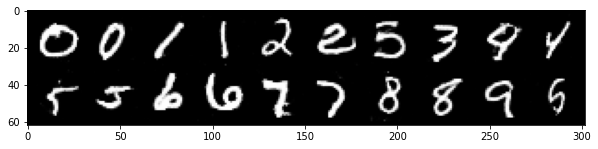

tensor([0, 0, 1, 1, 2, 2, 5, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 5],
       device='cuda:0')

In [11]:
# Minimize losss (crossnetropy) such that WD(x0, x1) < epsilon
distance = GeomLoss(SamplesLoss("sinkhorn", p=1, blur=0.1, scaling=0.5), DecodedDistribution(generator))
constraint = ConstraintDistance(z_data, distance, 0.0025)
projection = ProjectionBinarySearch(constraint, inside=True, threshold=0.0005)
objective = Objective(y_data, nn.CrossEntropyLoss(), combined, targeted=False)
z_per = projected_gd(z_data, objective, projection, grad_norm='l2', steps=20, step_size=0.1, clip=None)

grid_plot(generator.decode(z_per), nrows=10)
combined(z_per).argmax(1)

### Projection using binary search
- No objective, simplest way to satisfy constraint.

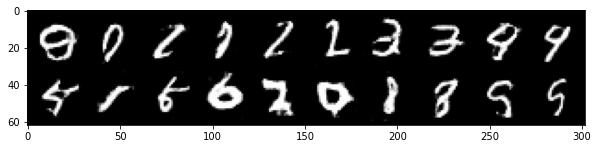

tensor([[9, 7, 2, 7, 1, 1, 2, 2, 8, 9, 4, 1, 5, 0, 2, 0, 1, 3, 5, 5],
        [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]],
       device='cuda:0')


In [16]:
z_per = bisection_method(z0, z, combined)
grid_plot(generator.decode(z_per), nrows=10)
print(combined(z_per).topk(2)[1].T)

## 2.2 Minimize distance
- Misclassification is constraint

### Pentaly method

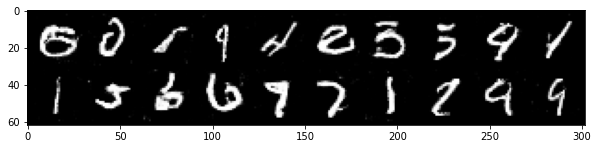

tensor([5, 2, 5, 9, 4, 8, 5, 5, 9, 1, 1, 3, 3, 0, 9, 2, 1, 1, 4, 4],
       device='cuda:0')

In [6]:
rho = SchedulerStep(10e8, gamma=1, n=10)
xi = SchedulerExponential(initial=1, gamma=0.01)
distance = L2(Decoded(generator))
z_per = penalty_method(z0, distance, combined, xi, rho, grad_norm='l2', iters=1000)

nan = z_per.isnan().all(1).flatten()
grid_plot(generator.decode(z_per[~nan]), nrows=10)
combined(z_per[~nan]).argmax(1)

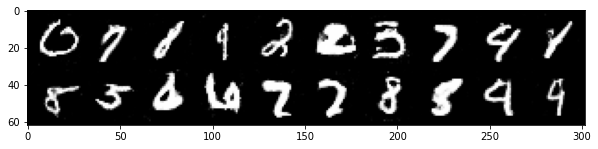

tensor([6, 7, 8, 4, 8, 8, 7, 7, 9, 1, 8, 3, 0, 4, 2, 2, 3, 5, 4, 4],
       device='cuda:0')

In [104]:
loss_function = SamplesLoss("sinkhorn", p=1, blur=0.1, scaling=0.5)
distance = GeomLoss(loss_function, DecodedDistribution(generator))

rho = SchedulerStep(10e8, gamma=1, n=10)
xi = SchedulerExponential(initial=1, gamma=0.01)
z_per = penalty_method(z0, distance, combined, xi, rho, iters=1000)

grid_plot(generator.decode(z_per), nrows=10)
combined(z_per).argmax(1)

### Projection method

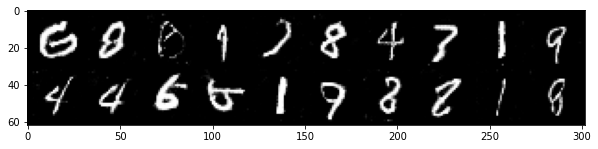

tensor([6, 8, 8, 4, 1, 8, 4, 7, 1, 9, 4, 4, 5, 5, 1, 9, 2, 2, 1, 8],
       device='cuda:0')

In [12]:
generator = MnistALI()
combined = lambda z: classifier(generator.decode(z))

distance = L2(Decoded(generator))
xi_o = SchedulerConstant(alpha=1)
xi_c = SchedulerPower(initial=1, power=-1/2)
z_per = projection_method(z0, z, distance, combined, xi_c, xi_o, grad_norm_o='l2', grad_norm_c='l2', iters=150)

grid_plot(generator.decode(z_per), nrows=10)
combined(z_per).argmax(1)

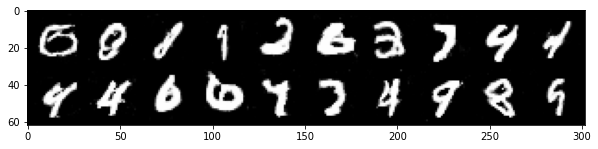

tensor([5, 8, 8, 9, 3, 6, 2, 7, 9, 1, 9, 4, 0, 0, 4, 3, 4, 9, 8, 5],
       device='cuda:0')

In [13]:
loss_function = SamplesLoss("sinkhorn", p=1, blur=0.1, scaling=0.5)
distance = GeomLoss(loss_function, DecodedDistribution(generator))
xi_o = SchedulerConstant(alpha=1)
xi_c = SchedulerPower(initial=1, power=-1/2)
z_per = projection_method(z0, z, distance, combined, xi_c, xi_o, grad_norm_o='l2', grad_norm_c='l2', iters=150)

grid_plot(generator.decode(z_per), nrows=10)
combined(z_per).argmax(1)

# 3. Partial Generators

### Level 0 - Generator

In [3]:
xi_o = SchedulerConstant(alpha=1)
xi_c = SchedulerPower(initial=1, power=-1/2)

gp_generator = MnistALI(0)
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)
v = gp_generator.encode(z)

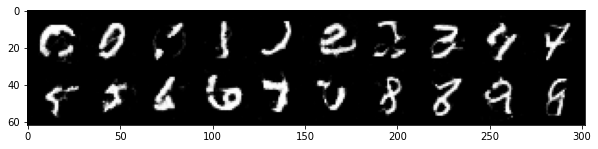

tensor([9, 9, 5, 3, 1, 3, 2, 2, 7, 7, 4, 3, 5, 3, 3, 3, 3, 3, 2, 8],
       device='cuda:0')


In [7]:
distance = L2(Decoded(gp_generator))
z_per = projection_method(v0, v, distance, gp_combined, xi_c, xi_o, iters=150)

grid_plot(gp_generator.decode(z_per), nrows=10)
print(gp_combined(z_per).argmax(1))

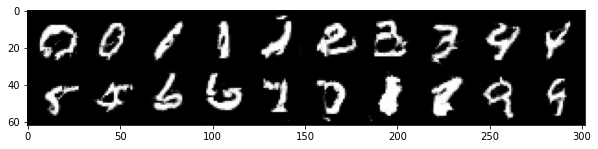

tensor([9, 9, 6, 0, 1, 8, 2, 2, 9, 8, 8, 4, 5, 5, 1, 0, 1, 2, 8, 8],
       device='cuda:0')
Wall time: 2min 47s


In [9]:
loss_function = SamplesLoss("sinkhorn", p=1, blur=0.1, scaling=0.5)
distance = GeomLoss(loss_function, DecodedDistribution(gp_generator))
z_per = projection_method(v0, v, distance, gp_combined, xi_c, xi_o, iters=150)

grid_plot(gp_generator.decode(z_per), nrows=10)
print(gp_combined(z_per).argmax(1))

### Level 1 - Generator

In [14]:
xi_o = SchedulerConstant(alpha=1)
xi_c = SchedulerPower(initial=1, power=-1/2)

gp_generator = MnistALI(1)
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)
v = gp_generator.encode(z)

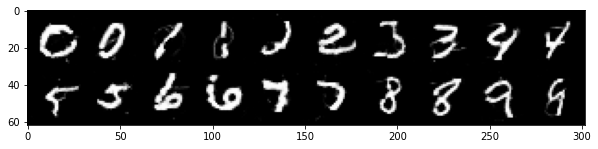

tensor([5, 9, 3, 0, 1, 3, 1, 2, 9, 7, 4, 3, 5, 3, 3, 3, 3, 3, 2, 8],
       device='cuda:0')


In [15]:
distance = L2(Decoded(gp_generator))
z_per = projection_method(v0, v, distance, gp_combined, xi_c, xi_o, iters=150)

grid_plot(gp_generator.decode(z_per), nrows=10)
print(gp_combined(z_per).argmax(1))

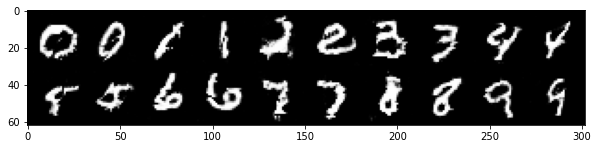

tensor([9, 9, 0, 6, 1, 8, 2, 7, 3, 8, 4, 4, 5, 5, 3, 3, 1, 2, 3, 8],
       device='cuda:0')


In [16]:
loss_function = SamplesLoss("sinkhorn", p=1, blur=0.1, scaling=0.5)
distance = GeomLoss(loss_function, DecodedDistribution(gp_generator))
z_per = projection_method(v0, v, distance, gp_combined, xi_c, xi_o, iters=150)

grid_plot(gp_generator.decode(z_per), nrows=10)
print(gp_combined(z_per).argmax(1))

### Level 2 - Generator

In [17]:
xi_o = SchedulerConstant(alpha=1)
xi_c = SchedulerPower(initial=1, power=-1/2)

gp_generator = MnistALI(2)
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)
v = gp_generator.encode(z)

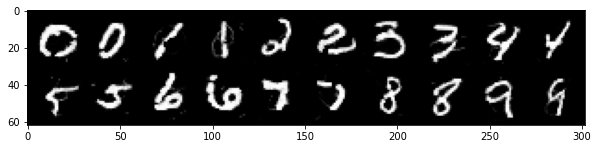

tensor([5, 7, 5, 0, 3, 3, 5, 2, 3, 1, 4, 3, 3, 3, 3, 3, 3, 3, 7, 8],
       device='cuda:0')


In [18]:
distance = L2(Decoded(gp_generator))
z_per = projection_method(v0, v, distance, gp_combined, xi_c, xi_o, iters=150)

grid_plot(gp_generator.decode(z_per), nrows=10)
print(gp_combined(z_per).argmax(1))

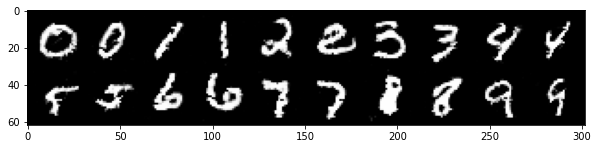

tensor([9, 9, 8, 3, 3, 8, 5, 7, 8, 8, 4, 7, 5, 5, 3, 3, 1, 7, 8, 8],
       device='cuda:0')


In [19]:
loss_function = SamplesLoss("sinkhorn", p=1, blur=0.1, scaling=0.5)
distance = GeomLoss(loss_function, DecodedDistribution(gp_generator))
z_per = projection_method(v0, v, distance, gp_combined, xi_c, xi_o, iters=150)

grid_plot(gp_generator.decode(z_per), nrows=10)
print(gp_combined(z_per).argmax(1))

### Level 3 - Generator

In [20]:
xi_o = SchedulerConstant(alpha=1)
xi_c = SchedulerPower(initial=1, power=-1/2)

gp_generator = MnistALI(3)
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)
v = gp_generator.encode(z)

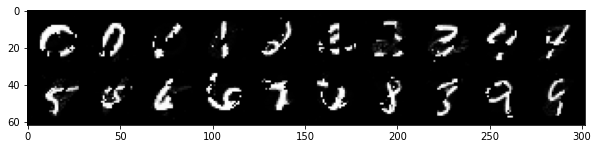

tensor([5, 7, 5, 5, 3, 3, 2, 2, 3, 7, 8, 8, 5, 3, 3, 3, 3, 3, 3, 8],
       device='cuda:0')


In [21]:
distance = L2(Decoded(gp_generator))
z_per = projection_method(v0, v, distance, gp_combined, xi_c, xi_o, iters=150)

grid_plot(gp_generator.decode(z_per), nrows=10)
print(gp_combined(z_per).argmax(1))

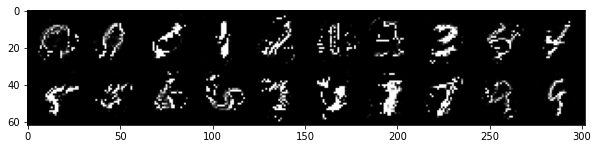

tensor([9, 8, 5, 3, 8, 8, 9, 2, 3, 3, 8, 3, 5, 5, 3, 3, 7, 7, 8, 5],
       device='cuda:0')


In [22]:
loss_function = SamplesLoss("sinkhorn", p=1, blur=0.1, scaling=0.5)
distance = GeomLoss(loss_function, DecodedDistribution(gp_generator))
z_per = projection_method(v0, v, distance, gp_combined, xi_c, xi_o, iters=150)

grid_plot(gp_generator.decode(z_per), nrows=10)
print(gp_combined(z_per).argmax(1))